# Exercise 1.2 - Forward Flux Sampling

In [99]:
from enum import Enum, auto
from pathlib import Path

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import tqdm.contrib.concurrent
from tqdm.notebook import tqdm as tqdm_

import soft_matter.sample
import soft_matter.energy
import soft_matter.dynamics

In [2]:
NUM_SEGMENTS = 16
A_SEGMENTS = 4

np.random.seed(42)  # make experiments reproducible
data_dir = Path.cwd() / ".." / "data"
figure_dir = Path.cwd() / ".." / "report" / "figures"

## Define forward flux interfaces

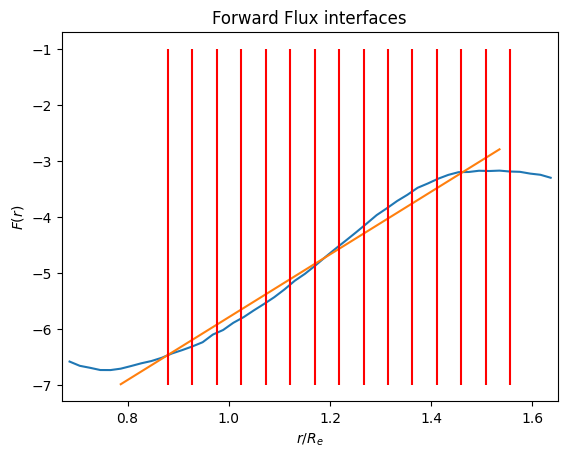

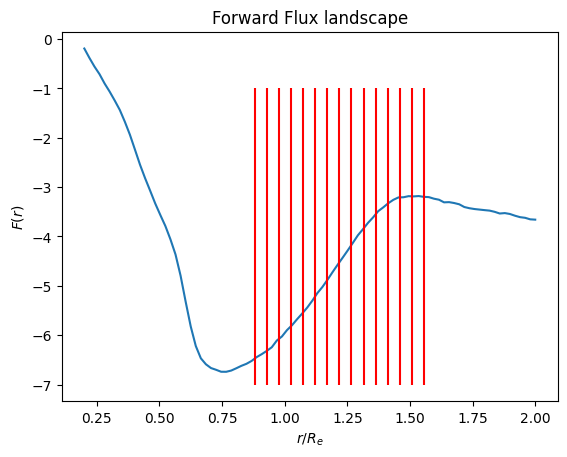

In [3]:
rs, free_energy = np.loadtxt(data_dir / "ex1_free_energy_profile.dat").T
start, end = .72, 1.6
mask = np.logical_and(start - .05 < rs, rs < end + .05)
linreg_mask = np.logical_and(start + .05 < rs, rs < end - .05)

lower = np.min(free_energy[mask])
upper = np.max(free_energy[mask]) + .5  # we want to go far over the barrier
delta_f_spacing = .4
num_interfaces = (upper - lower) // delta_f_spacing + 6  # make a little more and also rounding
linreg = scipy.stats.linregress(rs[linreg_mask], free_energy[linreg_mask])

free_energy_space = np.linspace(lower, upper, num=int(num_interfaces))[1:]
interfaces = (free_energy_space - linreg.intercept) / linreg.slope  # type: ignore

plt.plot(rs[mask], free_energy[mask])
plt.plot(rs[linreg_mask], linreg.slope * rs[linreg_mask] + linreg.intercept)  # type: ignore
for r in interfaces:
    plt.vlines(r, -1, -7, color="r")
plt.xlim(start - .05, end + .05)
plt.ylabel("$F(r)/k_B T$")
plt.xlabel("$r/R_e$")
plt.title("Forward Flux interfaces")
plt.savefig(figure_dir / "ex2_forward_flux_interfaces.pdf")
plt.show()

plt.plot(rs, free_energy)
for r in interfaces:
    plt.vlines(r, -1, -7, color="r")
plt.ylabel("$F(r)/k_B T$")
plt.xlabel("$r/R_e$")
plt.title("Forward Flux landscape")
plt.savefig(figure_dir / "ex2_forward_flux_landscape.pdf")
plt.show()

## Generate as many initial configurations as necessary.

In [97]:
drop_start = 1_000
energy = soft_matter.energy.energy_with_external_fields

def initial_configs(init=None, sample_n=np.inf):
    if init is None:
        old_polymer = soft_matter.sample.sample_initial(NUM_SEGMENTS)
    else:
        old_polymer = init
    energy_old = energy(old_polymer)

    steps = 1
    samples = 0
    while True:
        new_polymer = soft_matter.dynamics.polymer_step(old_polymer)
        energy_new = energy(new_polymer)

        acceptance_rate = np.exp(energy_old - energy_new)
        mc_number = np.random.rand()
        if mc_number < acceptance_rate:  # accepted
            old_polymer = new_polymer
            energy_old = energy_new
        if steps > drop_start and steps % (NUM_SEGMENTS * drop_start // 50) == 0:
            yield old_polymer
            samples += 1
        steps += 1
        if steps >= sample_n: break

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, '$\\rho(r_j)$')

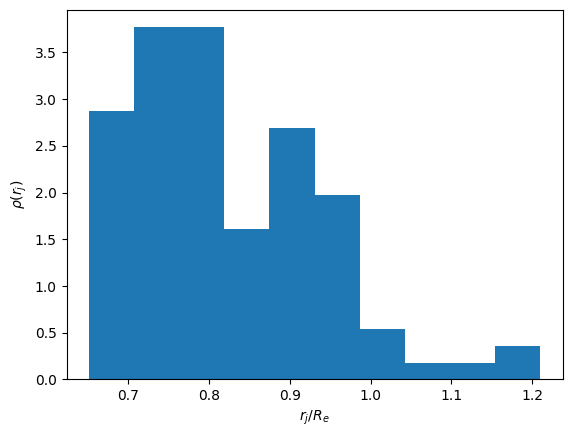

In [101]:
def junction_point(polymer_ens, to_rad=False):
    cartesian = (polymer_ens[..., A_SEGMENTS, :] + polymer_ens[..., A_SEGMENTS + 1, :]) / 2
    if to_rad:
        return soft_matter.energy.polymer_pos_to_rad(cartesian)
    return cartesian


config_generator = initial_configs()
configs = []
for _ in tqdm_(range(100)):
    configs.append(next(config_generator))

configs = map(junction_point, configs)
configs = list(map(soft_matter.energy.polymer_pos_to_rad, configs))
plt.hist(configs, density=True, stacked=True, bins=10)
plt.xlabel("$r_j/R_e$")
plt.ylabel("$\\rho(r_j)$")

## Do some fluxes

In [112]:
max_steps = 1_000

class Result(Enum):
    NOT_REACHED = auto()
    REACHED_UPPER = auto()
    REACHED_LOWER = auto()

def forward_flux_sim(old_polymer, lower, upper):
    # sometimes the polymer has already crossed the next boundary
    reaction_coordinate = junction_point(old_polymer, to_rad=True)
    if reaction_coordinate > upper:
        return Result.REACHED_UPPER, old_polymer
    if reaction_coordinate < lower:
        return Result.REACHED_LOWER, None
        
    energy_old = energy(old_polymer)
    for step in range(max_steps * NUM_SEGMENTS):
        new_polymer = soft_matter.dynamics.polymer_step(old_polymer)
        energy_new = energy(new_polymer)

        acceptance_rate = np.exp(energy_old - energy_new)
        mc_number = np.random.rand()
        if mc_number > acceptance_rate:  # rejected
            continue

        old_polymer = new_polymer
        energy_old = energy_new

        reaction_coordinate = junction_point(new_polymer, to_rad=True)
        if reaction_coordinate > upper:
            return Result.REACHED_UPPER, new_polymer
        if reaction_coordinate < lower:
            return Result.REACHED_LOWER, None
    else:
        return Result.NOT_REACHED, None

## Sample some configurations that reach the first boundary

In [113]:
interface_ens_size = 1_000

def in_basin(trial):
    reaction_coordinate = junction_point(trial, to_rad=True)
    if reaction_coordinate > interfaces[0]:
        return False
    else:
        return True

    
while True:
    trial = next(initial_configs())
    if in_basin(trial): break
        
def make_n_configs(n):
    configs = []
    generator = initial_configs(init=trial)
    while len(configs) < n:
        config = next(generator)
        if in_basin(config):
            configs.append(config)
    return configs

jpw = np.ceil(interface_ens_size / 32).astype(np.int64)
basin_samples = tqdm.contrib.concurrent.process_map(make_n_configs, [jpw for _ in range(np.ceil(interface_ens_size / jpw).astype(np.int64))])  # i got 32 cpus
basin_samples = [p for sublist in configs for p in sublist]

  0%|          | 0/32 [00:00<?, ?it/s]

In [114]:
on_first_interface = tqdm.contrib.concurrent.process_map(forward_flux_sim, basin_samples, [-1 for _ in configs], [interfaces[0] for _ in configs], chunksize=5)
on_first_interface = [polymer for _, polymer in on_first_interface]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [120]:
on_second_interface = tqdm.contrib.concurrent.process_map(forward_flux_sim, on_first_interface, [-1 for _ in configs], [interfaces[1] for _ in configs], chunksize=5)
on_second_interface = [polymer for _, polymer in on_second_interface]

  0%|          | 0/1024 [00:00<?, ?it/s]

0.8798904931152783 0.9281967635644188


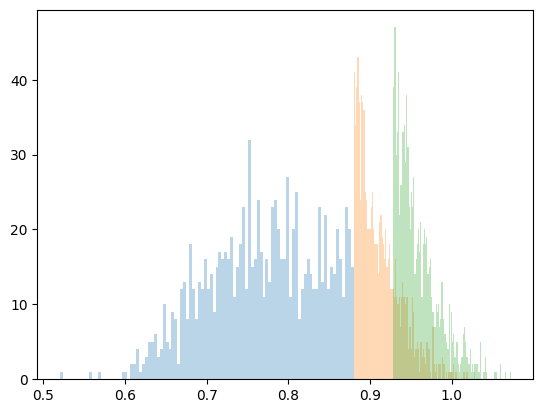

In [121]:
plt.hist(junction_point(np.array(configs), to_rad=True), bins=100, alpha=.3, label="basin")
plt.hist(junction_point(np.array(on_first_interface), to_rad=True), bins=100, alpha=.3, label="1st boundary")
plt.hist(junction_point(np.array(on_second_interface), to_rad=True), bins=100, alpha=.3, label="2nd boundary")
plt.hline(interfaces[0], 0, 50, color="r")
plt.hline(interfaces[1], 0, 50, color="r")
plt.legend()
plt.savefig(figure_dir / "ex2_transition_over_interface.pdf")

## Calculate the transition rates

In [186]:
eta_zero = 1

def transition_rate(seed=42):
    np.random.seed(seed)
    configs_on_interface = np.array(on_second_interface)

    rate = eta_zero
    for idx_interface in range(1, len(interfaces) - 1):
        lower, upper = interfaces[idx_interface - 1], interfaces[idx_interface + 1]

        forward = 0
        back = 0
        on_next_interface = []
        while len(on_next_interface) < interface_ens_size:
            config_idx = np.random.choice(len(configs_on_interface))
            config = configs_on_interface[config_idx]
            result, polymer = forward_flux_sim(config, lower, upper)
            if result is Result.REACHED_UPPER:
                on_next_interface.append(polymer)
                forward += 1
            if result is Result.REACHED_LOWER:
                back += 1
            #print(f"{back=} {forward=}", end="\r")
                
        configs_on_interface = np.array(on_next_interface)
        rate *= forward / (back + forward)
        #print(f"{rate=}, ({len(configs_on_interface)}) {configs_on_interface[0]}")
    return rate

  0%|          | 0/25 [00:00<?, ?it/s]

4.241154752237447e-06 +/- 9.659298775076728e-07


(array([3., 1., 4., 2., 3., 2., 1., 3., 2., 4.]),
 array([2.59291086e-06, 2.91084797e-06, 3.22878509e-06, 3.54672220e-06,
        3.86465931e-06, 4.18259642e-06, 4.50053354e-06, 4.81847065e-06,
        5.13640776e-06, 5.45434487e-06, 5.77228199e-06]),
 <BarContainer object of 10 artists>)

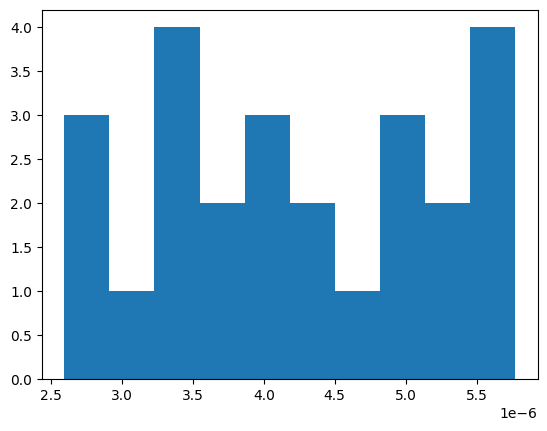

In [188]:
rates = tqdm.contrib.concurrent.process_map(transition_rate, range(25))
print(f"{np.mean(rates)} +/- {np.std(rates)}")
plt.hist(rates)